In [26]:
from nba_api.stats.endpoints import leaguedashplayerstats
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.decomposition import PCA

In [27]:
player_stats = leaguedashplayerstats.LeagueDashPlayerStats(
    season='2024-25',
    per_mode_detailed='PerGame'
)
df = player_stats.get_data_frames()[0]

df['top_fantasy'] = (df['NBA_FANTASY_PTS_RANK'] <= 50).astype(int)

feature_cols = [
    'PTS_RANK', 'REB_RANK', 'AST_RANK', 'STL_RANK', 'BLK_RANK', 'TOV_RANK', 
    'GP_RANK', 'MIN_RANK', 'FGM_RANK', 'FG3M_RANK', 'FTM_RANK'  
]

df = df.dropna(subset=feature_cols)

X = df[feature_cols]
y = df['top_fantasy']  

In [28]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [29]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1, 26)),
    'weights': ['uniform', 'distance']
}

metrics = ['recall', 'f1', 'accuracy']
best_params = {}

for metric in metrics:
    grid = GridSearchCV(
        knn, 
        param_grid, 
        scoring=metric,
        cv=5
    )
    grid.fit(X_train_scaled, y_train)
    best_params[metric] = grid.best_params_

best_params

{'recall': {'n_neighbors': 8, 'weights': 'distance'},
 'f1': {'n_neighbors': 8, 'weights': 'distance'},
 'accuracy': {'n_neighbors': 8, 'weights': 'distance'}}

In [30]:
final_k = best_params['accuracy']['n_neighbors']
final_w = best_params['accuracy']['weights']

knn_final = KNeighborsClassifier(
    n_neighbors=final_k,
    weights=final_w
)

knn_final.fit(X_train_scaled, y_train)

y_pred = knn_final.predict(X_test_scaled)
y_prob = knn_final.predict_proba(X_test_scaled)[:,1]

In [31]:
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

print("Final Model Metrics:")
print("Accuracy:", acc)
print("Recall:", rec)
print("F1 Score:", f1)
print("ROC AUC:", roc)

Final Model Metrics:
Accuracy: 0.956140350877193
Recall: 0.6
F1 Score: 0.7058823529411765
ROC AUC: 0.9932692307692308


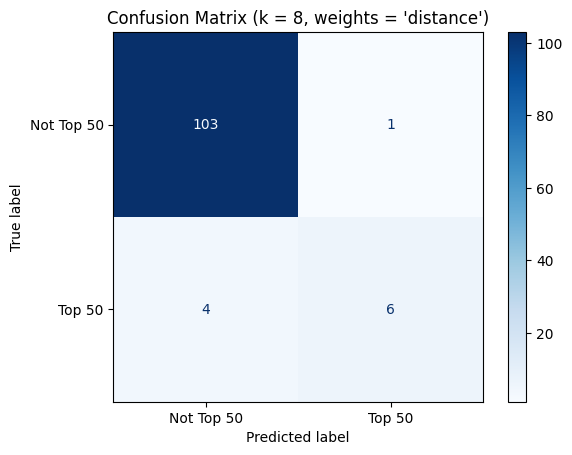

In [32]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Top 50', 'Top 50'])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (k = {final_k}, weights = '{final_w}')")
plt.show()

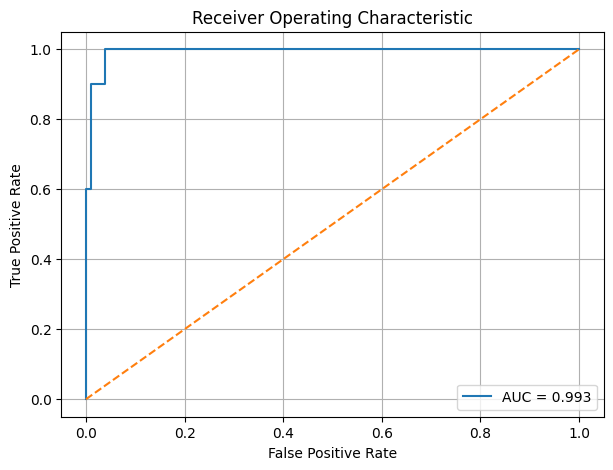

In [33]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.grid()
plt.show()

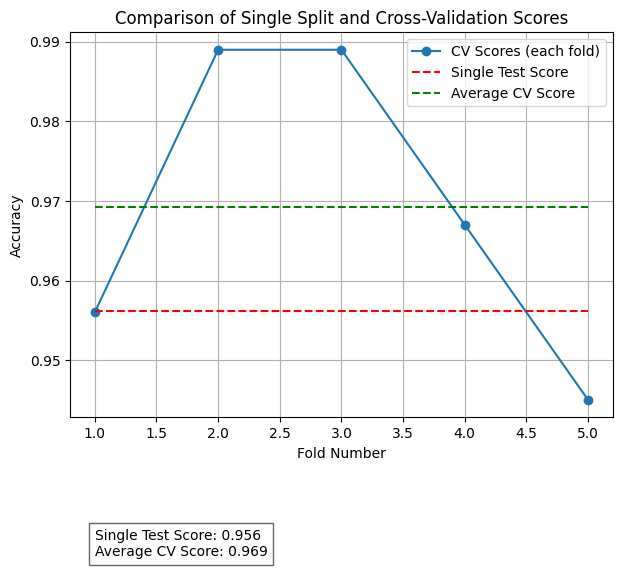

In [34]:
cv_scores = cross_val_score(
    knn_final, 
    X_train_scaled,
    y_train,
    cv=5,
    scoring='accuracy'
)

plt.figure(figsize=(7,5))
plt.plot(range(1,6), cv_scores, marker='o', label='CV Scores (each fold)')
plt.hlines(acc, xmin=1, xmax=5, colors='red', linestyles='--', label='Single Test Score')
plt.hlines(cv_scores.mean(), xmin=1, xmax=5, colors='green', linestyles='--', label='Average CV Score')

plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("Comparison of Single Split and Cross-Validation Scores")
plt.text(1, min(cv_scores) - 0.02, f"Single Test Score: {acc:.3f}\nAverage CV Score: {cv_scores.mean():.3f}",
         verticalalignment='bottom', horizontalalignment='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.legend()
plt.grid()
plt.show()

In [46]:
features = [
    'PTS', 'AST', 'REB', 'STL', 'BLK'
]
Xfeatures = df[features]
scaled_features = scaler.fit_transform(Xfeatures)

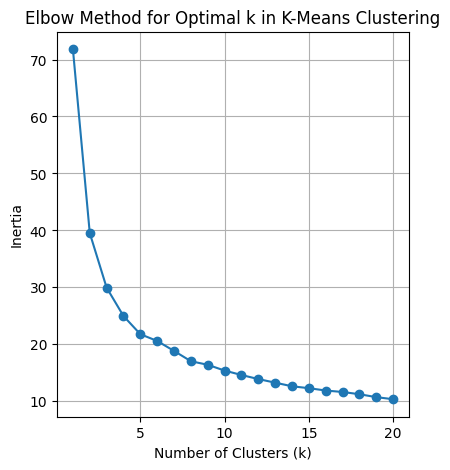

In [47]:
intertia = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    intertia.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(1, 21), intertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k in K-Means Clustering")
plt.grid()
plt.show()

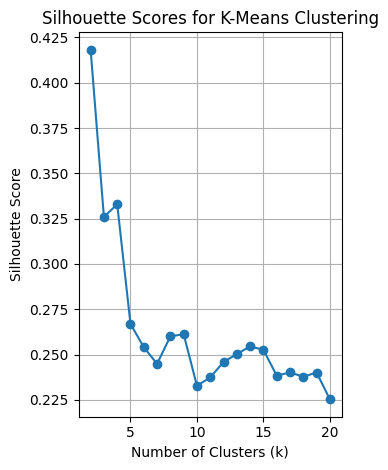

In [48]:
slihouette_scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    slihouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

plt.subplot(1,2,1)
plt.plot(range(2, 21), slihouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for K-Means Clustering")
plt.grid()
plt.tight_layout()
plt.show()

In [49]:
kmeans = KMeans(n_clusters=3, random_state=3001)
kmeans.fit(scaled_features)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,3001
,copy_x,True
,algorithm,'lloyd'


In [50]:
df['Cluster'] = kmeans.labels_
df
cluster_sizes = df['Cluster'].value_counts()
print(cluster_sizes)

Cluster
1    244
2    224
0    101
Name: count, dtype: int64


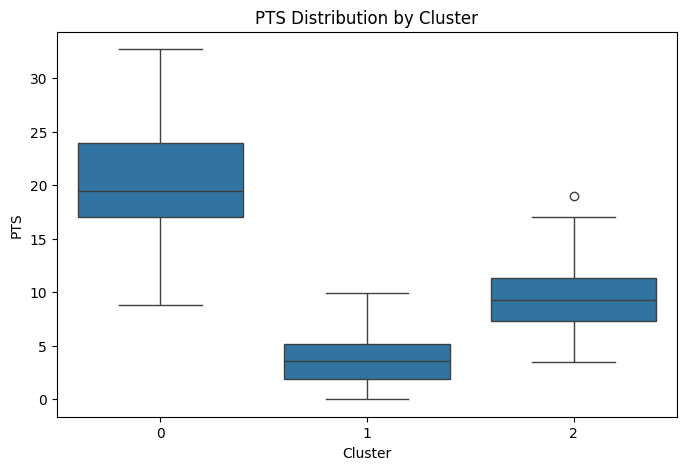

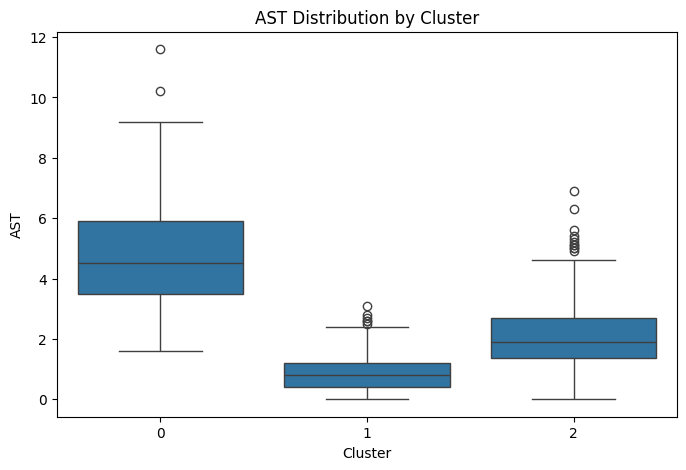

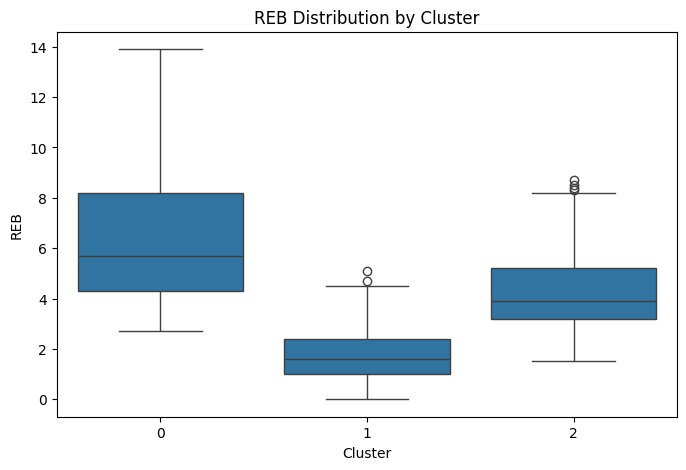

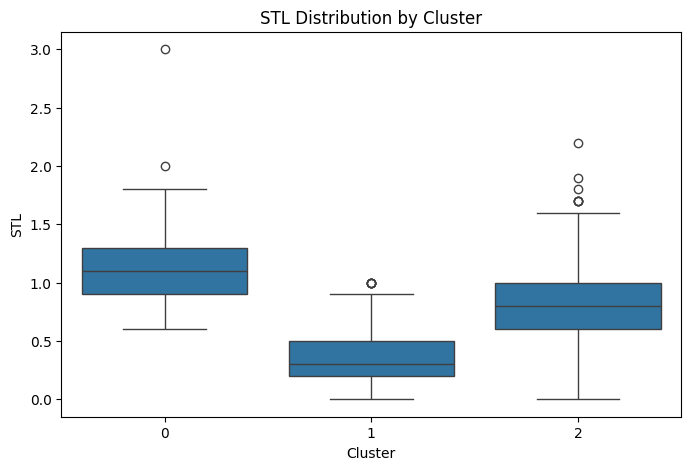

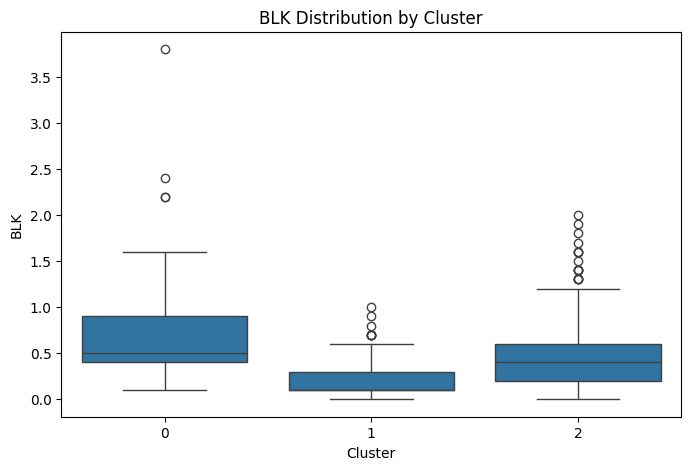

In [51]:
for feature in [
    'PTS', 'AST', 'REB', 'STL', 'BLK'
]:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f"{feature} Distribution by Cluster")
    plt.show()

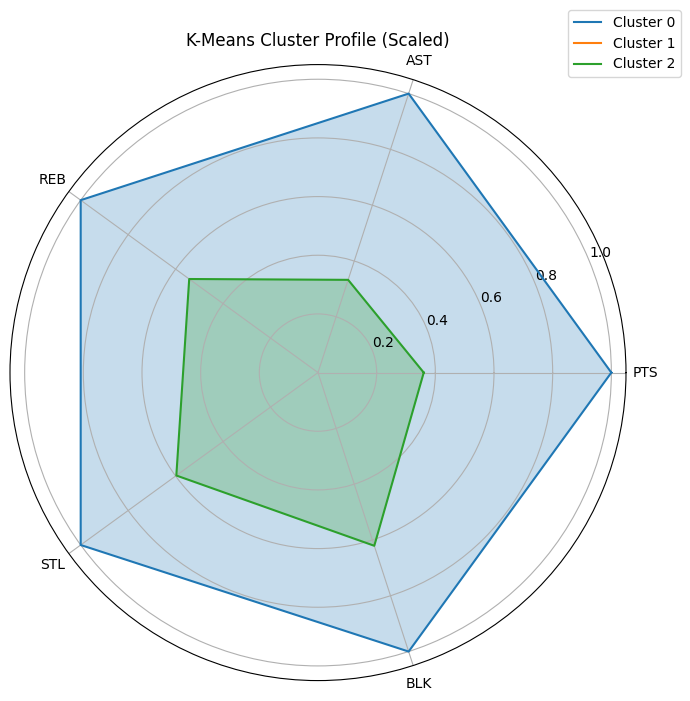

In [ ]:


features = ['PTS', 'AST', 'REB', 'STL', 'BLK']
cluster_means = df.groupby('Cluster')[features].mean()


scaler_plot = MinMaxScaler()
cluster_means_scaled = pd.DataFrame(
    scaler_plot.fit_transform(cluster_means),
    columns=features,
    index=cluster_means.index
)

num_features = len(features)
angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
angles += angles[:1]


fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))


for cluster in cluster_means_scaled.index:
    values = cluster_means_scaled.loc[cluster].tolist()
    values += values[:1] 
    ax.plot(angles, values, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.25)


ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)


plt.title('K-Means Cluster Profile (Scaled)')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()



In [73]:
df['bottom100_fantasy'] = ((df['NBA_FANTASY_PTS_RANK'] > 469) & (df['NBA_FANTASY_PTS_RANK'] <= 569)).astype(int)

df['cluster'] = kmeans.labels_

bottom = df[df['bottom100_fantasy'] == 1]

bottom['cluster'].value_counts()

cluster
1    100
Name: count, dtype: int64